In [1]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
from collections import deque
import flappy_bird_gym
import time

In [2]:
def moving_average(a, n=3): 
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(in_features=state_space_dim,out_features=128), 
            nn.ReLU(True),
            nn.Linear(in_features=128,out_features=128), 
            nn.ReLU(True),
            nn.Linear(in_features=128,out_features=action_space_dim)
        )

    def forward(self, x):
        return self.linear(x) 

In [4]:
class DQNAgent:
    def __init__(self, params):
        
        self.state_size = params['state_size']
        self.action_size = params['action_size']
        
        self.memory = deque(maxlen = 15_000)
        self.min_sampl = 500
        
        self.target_up = params['target_up']
        
        self.gamma = params['gamma']
        
        self.eps = 1.
        
        self.model = DQN(self.state_size, self.action_size)
        self.t_model = DQN(self.state_size, self.action_size)
        self.t_model.load_state_dict(self.model.state_dict())
        
        self.opt = torch.optim.Adam(self.model.parameters(), lr=params['lr'])
        self.loss_fn = nn.SmoothL1Loss()
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if np.random.rand() <= self.eps:
            return np.random.randint(self.action_size)
        with torch.no_grad():
            act_values = self.model(state)
        return torch.argmax(act_values).item()
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                with torch.no_grad():
                    target = (reward + self.gamma * torch.max(self.t_model(next_state)))
            
            target = torch.tensor(target).reshape((1))
            predected = self.model(state)[:,action]
               
                
            #print(predected, target)
            loss = self.loss_fn(predected, target)

            self.opt.zero_grad()
            loss.backward()
        
        if self.eps > self.eps_min:
            self.eps *= self.eps_decay
            
            
    def replay_2(self,batch_size):
        
        # Sample the data from the replay memory
        batch = random.sample(self.memory, batch_size)

        # Create tensors for each element of the batch
        states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
        actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
        rewards     = torch.tensor([s[2] for s in batch], dtype=torch.float32)

        # Compute a mask of non-final states (all the elements where the next state is not None)
        non_final_next_states = torch.tensor([s[3] for s in batch if s[3] is not None], dtype=torch.float32) # the next state can be None if the game has ended
        non_final_mask = torch.tensor([s[3] is not None for s in batch], dtype=torch.bool)

        # Compute all the Q values (forward pass)
        self.model.train()
        q_values = self.model(states)
        # Select the proper Q value for the corresponding action taken Q(s_t, a)
        state_action_values = q_values.gather(1, actions.unsqueeze(1))

        # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
        with torch.no_grad():
            self.t_model.eval()
            q_values_target = self.t_model(non_final_next_states)
        next_state_max_q_values = torch.zeros(batch_size)
        next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

        # Compute the expected Q values
        expected_state_action_values = rewards + (next_state_max_q_values * self.gamma)
        expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

        # Compute the Huber loss
        loss = self.loss_fn(state_action_values, expected_state_action_values)

        # Optimize the model
        self.opt.zero_grad()
        loss.backward()
        # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
        nn.utils.clip_grad_norm_(self.model.parameters(), 2)
        self.opt.step()
        
        #if self.eps > self.eps_min:
        #    self.eps *= self.eps_decay

In [5]:
def train(agent, epochs, lamb):
    exp_decay = np.exp(-np.log(5) / epochs * lamb) 
    exploration_profile = [(exp_decay ** i) for i in range(epochs)]

    pbar = tqdm(range(epochs))
    SCORE = []
    for e in pbar:
        agent.eps = max(exploration_profile[e], 1e-4)
        state = env.reset()
        state = state.astype(np.float32)
        done = False
        score = 0
        step = 0
        while not done and step < 2000:

            step += 1
            
            state_t = torch.from_numpy(state).unsqueeze(0)
            action = agent.act(state_t)

            next_state, reward, done, _ = env.step(action)
            
            
            reward -= 1. * np.abs(state[1])
            
            next_state = next_state.astype(np.float32)
            if done:
                next_state = None

            agent.remember(state, action, reward, next_state, done)


            if len(agent.memory) > agent.min_sampl:
                agent.replay_2(32)

            state = next_state
            score += reward 

            
        SCORE.append(score)
        
        if e % agent.target_up == 0:
            agent.t_model.load_state_dict(agent.model.state_dict())

        if e % 10 == 0:
            mean_score = np.mean(SCORE[-10:])
            desc = 'Mean score: ' + str(int(mean_score)) + '\t' + str(agent.eps)
            pbar.set_description(desc)
        
            
        
    return SCORE

In [11]:
env = gym.make('FlappyBird-v0')


env.seed(1012390)
torch.manual_seed(1012903)
np.random.seed(1019023)
random.seed(1013902)

params = {
    'state_size': 2,
    'action_size': 2,
    'lr': 5e-3,
    'gamma': 0.97,
    'target_up': 10,
}

agent = DQNAgent(params)

epochs = 3000

lamb = 5

SCORE = train(agent, epochs, lamb)


env.close()

  0%|          | 0/3000 [00:00<?, ?it/s]

/tmp/ipykernel_57317/3858072732.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)


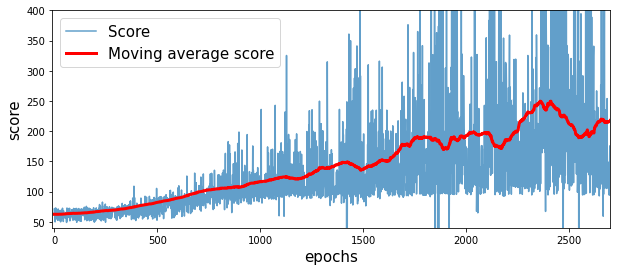

In [48]:
plt.figure(figsize=(10,4))
plt.plot(SCORE,label= 'Score', alpha = 0.7)
plt.plot(moving_average(SCORE,200), color= 'r', linewidth = 3 , label= 'Moving average score')
plt.ylim(40,400)
plt.xlim(-10,2700)
plt.xlabel("epochs",fontsize=15)
plt.ylabel("score",fontsize=15)

plt.legend(fontsize=15)

plt.savefig("img/flappy_conv.png",dpi = 300)

In [82]:
torch.save(agent.model.state_dict(), "flappy_model.h5")

In [6]:
params = {
    'state_size': 2,
    'action_size': 2,
    'lr': 5e-3,
    'gamma': 0.97,
    'target_up': 10,
}


tr_agent = DQNAgent(params)
tr_agent.model.load_state_dict(torch.load("flappy_model.h5"))


<All keys matched successfully>

In [10]:
env = gym.make('FlappyBird-v0') 
env.seed(102) 
state = env.reset()

tr_agent.eps = 0.

score = 0
done = False

frames = []

for i in tqdm(range(400)):
    state = state.astype(np.float32)
    state_t = torch.from_numpy(state).unsqueeze(0)
    action = tr_agent.act(state_t)
    next_state, reward, done, info = env.step(action)
    env.render()
    env.render()
    time.sleep(1/30)
    score += reward 
    state = next_state
    if done: break
    
env.close()


  0%|          | 0/400 [00:00<?, ?it/s]

In [8]:
from gym.wrappers import Monitor
env = Monitor(gym.make('FlappyBird-v0'), './Videos', force=True)
state = env.reset()
done = False
while not done:
    action = env.action_space.sample()
    state_next, reward, done, info = env.step(action)
env.close()
